In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

In [39]:
g4_tool = "g4hunter"

SPECIES_DATA = "../results/species_data.csv"
G4_PATH = f"../results/{g4_tool}_g4_distribution.csv"
    
# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Archaea': '#e78ac3',
    'Eukaryota': '#8da0cb',
}

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'

In [40]:
# species data
df_species = pd.read_csv(SPECIES_DATA)
df_species = df_species[["Accession", "Genome Size", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
print(df_species.shape)
df_species.head()

(108337, 4)


,Accession,Genome Size,Taxa,Domain
0,GCA_000002515.1,10689156.0,fungi,Eukaryota
1,GCA_031844645.1,6733472.0,bacteria,Bacteria
2,GCA_958295725.1,3665566.0,bacteria,Bacteria
3,GCA_000002765.3,23292622.0,protozoa,Eukaryota
4,GCA_000006645.1,4701745.0,bacteria,Bacteria


In [41]:
# g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
# log transform
df_g4["log10(Genome Size)"] = df_g4["Genome Size"].apply(lambda x: np.log10(x))
df_g4["log10(G4 count)"] = df_g4["g4_count"].apply(lambda x: np.log10(x+1))
df_g4["log10(G4 Density)"] = df_g4["G4 Density (per Mb)"].apply(lambda x: np.log10(x+1))
# filter out metagenomes and other taxa
df_g4 = df_g4[df_g4['Taxa'] != 'metagenomes']
df_g4 = df_g4[df_g4['Taxa'] != 'other']
print(df_g4.shape)
df_g4.head()

(108327, 9)


,Accession,g4_count,Genome Size,Taxa,Domain,G4 Density (per Mb),log10(Genome Size),log10(G4 count),log10(G4 Density)
0,GCA_000002515.1,356.0,10689156.0,fungi,Eukaryota,33.304781,7.028943,2.552668,1.535355
1,GCA_000002765.3,438.0,23292622.0,protozoa,Eukaryota,18.804238,7.367218,2.642465,1.296758
2,GCA_000002985.3,11196.0,100272607.0,invertebrate,Eukaryota,111.655619,8.001182,4.049102,2.051753
3,GCA_000006605.1,909.0,2476822.0,bacteria,Bacteria,367.002554,6.393895,2.959041,2.565851
4,GCA_000006645.1,765.0,4701745.0,bacteria,Bacteria,162.705549,6.672259,2.884229,2.214063


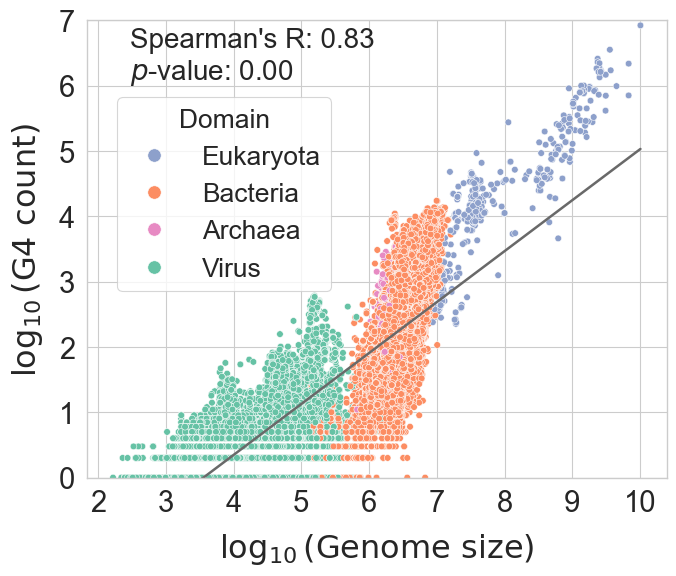

In [42]:
# plot the distribution of Genome size (log) vs G4 occurences (log10)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(7, 6))
# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}
sns.scatterplot(
    data=df_g4,
    x="log10(Genome Size)",
    y="log10(G4 count)",
    hue="Domain",
    palette=color_map,
    ax=ax
)
sns.regplot(
    data=df_g4,
    x="log10(Genome Size)",
    y="log10(G4 count)",
    scatter=False,
    color='dimgrey',
    ax=ax
)

# formatting
plt.ylim(0, 7)
plt.xlabel(r"$\log_{10}(\mathrm{Genome\ size})$", fontsize=23, labelpad=10)
plt.ylabel(r"$\log_{10}(\mathrm{G4\ count})$", fontsize=23, labelpad=10)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
ax.ticklabel_format(style='plain')
plt.legend(title="Domain", title_fontsize=19, fontsize=19, loc='upper left', bbox_to_anchor=(0.03, 0.86), markerscale=2.0)
plt.tight_layout()

# spearman correlation coefficient
corr, p = spearmanr(df_g4['log10(Genome Size)'], df_g4['log10(G4 count)'])
ax.text(0.075, 0.94, f"Spearman's R: {corr:.2f}", transform=ax.transAxes, fontsize=20)
ax.text(0.075, 0.87, rf"$\it{{p}}$-value: {p:.2f}", transform=ax.transAxes, fontsize=20)

plt.savefig(f"../plots/genome_size_g4_count_{g4_tool}.png", dpi=300)

Virus corr: 0.35 p-value: 0.00
Bacteria corr: 0.65 p-value: 0.00
Eukaryota corr: 0.89 p-value: 0.00
Archaea corr: 0.43 p-value: 0.00


Text(0.5, 0.98, 'Genome Size vs No. of G4s')

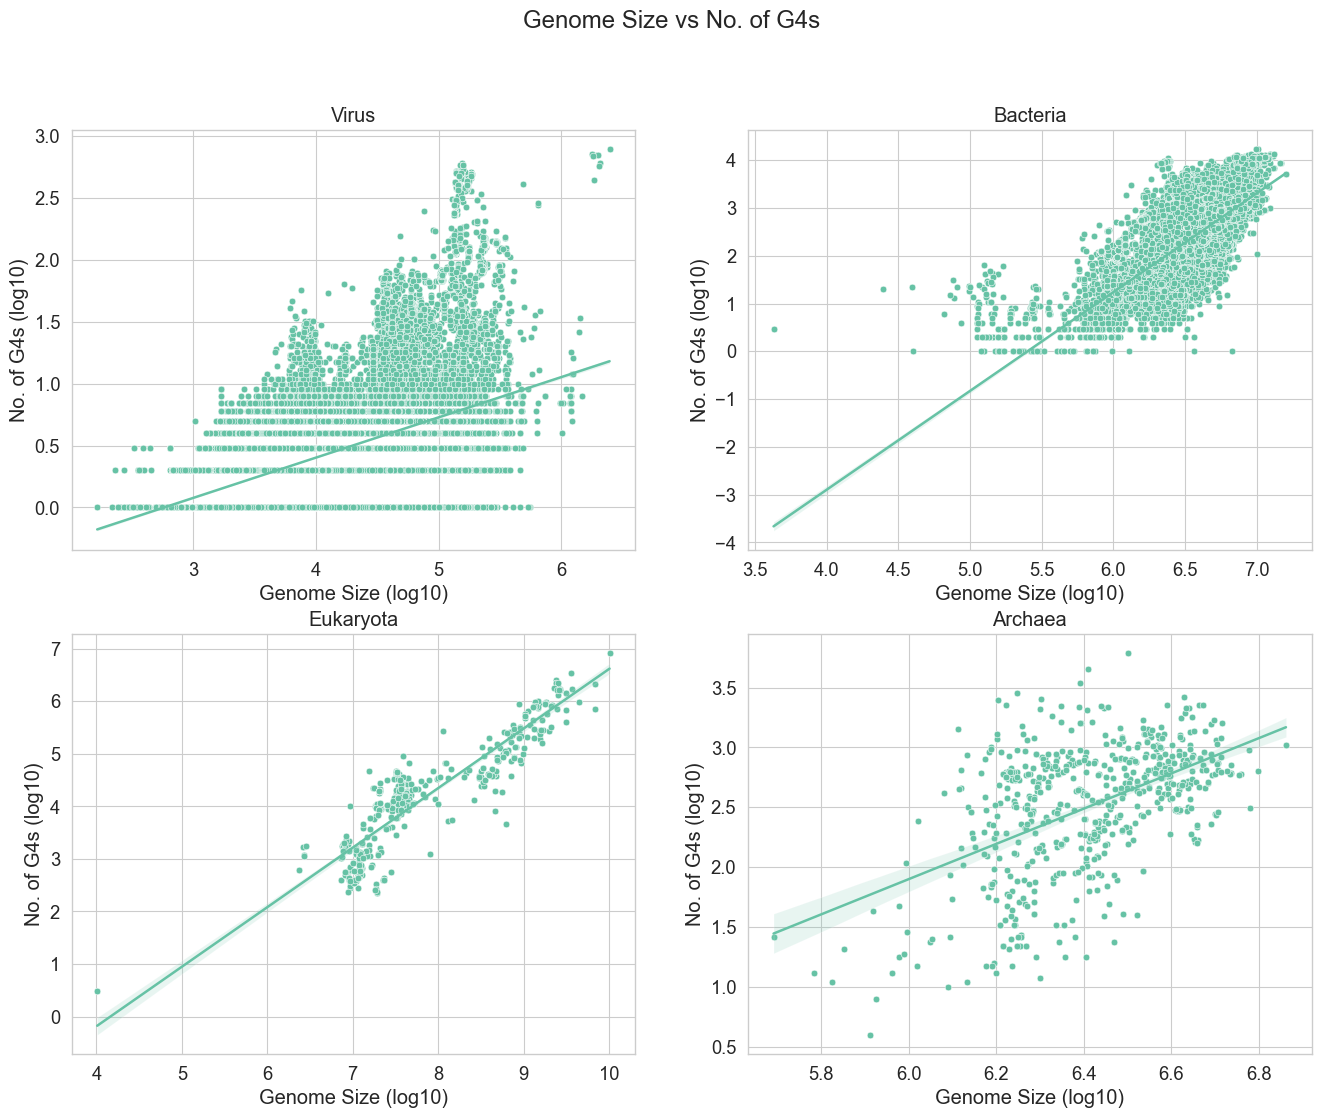

In [43]:
# plot the distribution of Genome size (log10) vs G4 occurences (log10) for each domain in a subplot
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

subplots = [[0, 0], [0, 1], [1, 0], [1, 1]]
for i in range(4):
	sns.scatterplot(
		data=df_g4[df_g4['Domain'] == list(color_map.keys())[i]],
		x="log10(Genome Size)",
		y="log10(G4 count)",
		ax=ax[subplots[i][0], subplots[i][1]]
	)
	sns.regplot(
		data=df_g4[df_g4['Domain'] == list(color_map.keys())[i]],
		x="log10(Genome Size)",
		y="log10(G4 count)",
		ax=ax[subplots[i][0], subplots[i][1]],
		scatter=False
	)
	ax[subplots[i][0], subplots[i][1]].set_title(list(color_map.keys())[i])
	ax[subplots[i][0], subplots[i][1]].set_xlabel("Genome Size (log10)")
	ax[subplots[i][0], subplots[i][1]].set_ylabel("No. of G4s (log10)")

	# spearman correlation coefficient
	corr, p = spearmanr(df_g4[df_g4['Domain'] == list(color_map.keys())[i]]['log10(Genome Size)'], df_g4[df_g4['Domain'] == list(color_map.keys())[i]]['log10(G4 count)'])
	print(f"{list(color_map.keys())[i]} corr: {corr:.2f}", f"p-value: {p:.2f}")

fig.suptitle("Genome Size vs No. of G4s")

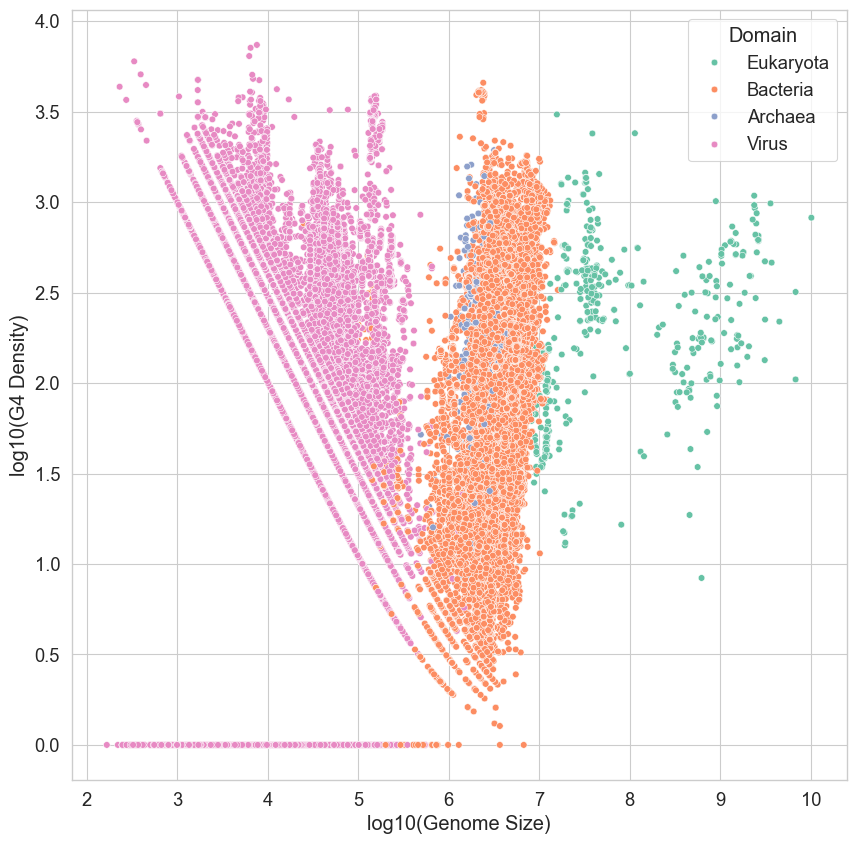

In [44]:
# plot the distribution of Genome Size vs G4 Density (per Mb)
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(
    data=df_g4,
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    hue="Domain",
    ax=ax
)
plt.savefig(f"../plots/genome_size_g4_density_{g4_tool}.png")

0 Virus
1 Bacteria
2 Archaea
3 Eukaryota


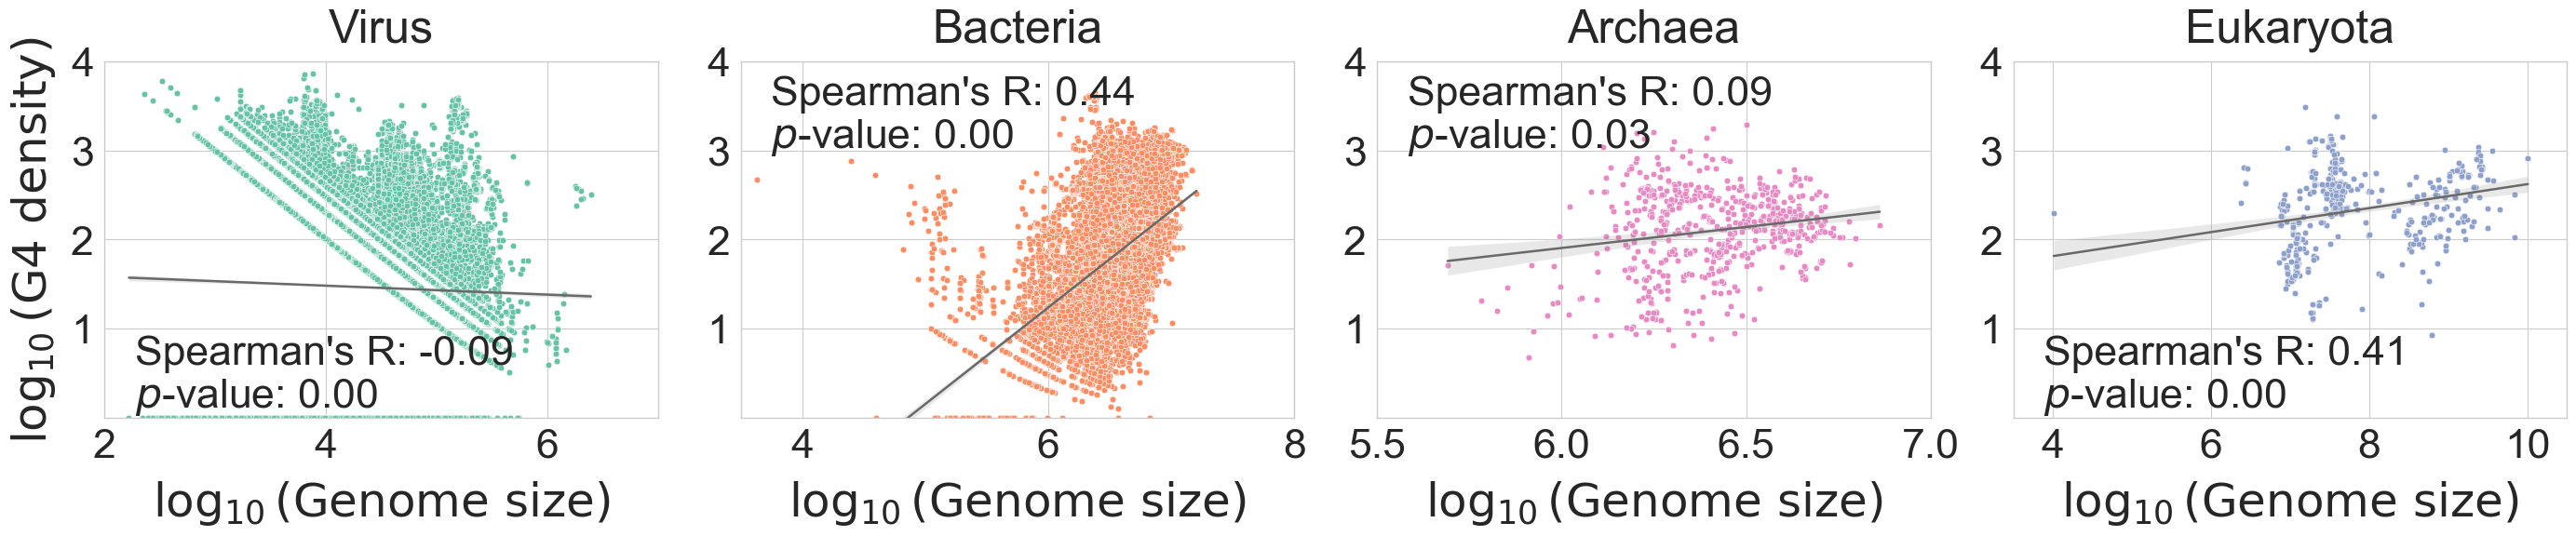

In [45]:
# plot the distribution of Genome size (log10) vs G4 Density (log10) for each domain in a subplot
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 4, figsize=(28, 6))

domains = ['Virus', 'Bacteria', 'Archaea', 'Eukaryota']
for i in range(4):
	print(i, domains[i])
	sns.scatterplot(
		data=df_g4[df_g4['Domain'] == domains[i]],
		x="log10(Genome Size)",
		y="log10(G4 Density)",
		ax=ax[i],
		color=color_map[domains[i]]
	)
	sns.regplot(
		data=df_g4[df_g4['Domain'] == domains[i]],
		x="log10(Genome Size)",
		y="log10(G4 Density)",
		ax=ax[i],
		scatter=False,
		color='dimgrey'
	)
	ax[i].set_title(domains[i], fontsize=36, pad=15)
	ax[i].set_xlabel(r"$\log_{10}(\mathrm{Genome\ size})$", fontsize=36, labelpad=10)

	if i == 0:
		ax[i].set_ylabel(r"$\log_{10}(\mathrm{G4\ density})$", fontsize=36, labelpad=10)
	else:
		ax[i].set_ylabel("")
	ax[i].set_ylim(0, 4)
	ax[i].set_yticks([1, 2, 3, 4])

	ax[i].tick_params(axis='both', which='major', labelsize=32)

# specify x axis limits for each subplot
ax[0].set_xlim(2,7)
ax[1].set_xlim(3.5,8)
ax[2].set_xlim(5.5,7)
ax[3].set_xlim(3.5,10.5)

# display correlation coefficient and p-values for each domain
virus_data = df_g4[df_g4['Domain'] == 'Virus']
bacteria_data = df_g4[df_g4['Domain'] == 'Bacteria']
archaea_data = df_g4[df_g4['Domain'] == 'Archaea']
eukaryota_data = df_g4[df_g4['Domain'] == 'Eukaryota']
virus_corr, virus_p = spearmanr(virus_data['log10(Genome Size)'], virus_data['log10(G4 Density)'])
bacteria_corr, bacteria_p = spearmanr(bacteria_data['log10(Genome Size)'], bacteria_data['log10(G4 Density)'])
archaea_corr, archaea_p = spearmanr(archaea_data['log10(Genome Size)'], archaea_data['log10(G4 Density)'])
eukaryota_corr, eukaryota_p = spearmanr(eukaryota_data['log10(Genome Size)'], eukaryota_data['log10(G4 Density)'])
ax[0].text(0.055, 0.15, f"Spearman's R: {virus_corr:.2f}", transform=ax[0].transAxes, fontsize=32)
ax[0].text(0.055, 0.03, rf"$\it{{p}}$-value: {virus_p:.2f}", transform=ax[0].transAxes, fontsize=32)
ax[1].text(0.055, 0.88, f"Spearman's R: {bacteria_corr:.2f}", transform=ax[1].transAxes, fontsize=32)
ax[1].text(0.055, 0.76, rf"$\it{{p}}$-value: {bacteria_p:.2f}", transform=ax[1].transAxes, fontsize=32)
ax[2].text(0.055, 0.88, f"Spearman's R: {archaea_corr:.2f}", transform=ax[2].transAxes, fontsize=32)
ax[2].text(0.055, 0.76, rf"$\it{{p}}$-value: {archaea_p:.2f}", transform=ax[2].transAxes, fontsize=32)
ax[3].text(0.055, 0.15, f"Spearman's R: {eukaryota_corr:.2f}", transform=ax[3].transAxes, fontsize=32)
ax[3].text(0.055, 0.03, rf"$\it{{p}}$-value: {eukaryota_p:.2f}", transform=ax[3].transAxes, fontsize=32)

plt.tight_layout()
plt.savefig(f"../plots/genome_size_g4_density_domain_{g4_tool}.png", dpi=300)

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_9671/1991927128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g4_virus["log10(Genome Size) binned"] = df_g4_virus["log10(Genome Size)"].apply(lambda x: int(x))
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_9671/1991927128.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["(1,2]", "(2,3]", "(3,4]", "(4,5]", "(5,6]"], fontsize=16)


[Text(0, 0, '(1,2]'),
 Text(1, 0, '(2,3]'),
 Text(2, 0, '(3,4]'),
 Text(3, 0, '(4,5]'),
 Text(4, 0, '(5,6]')]

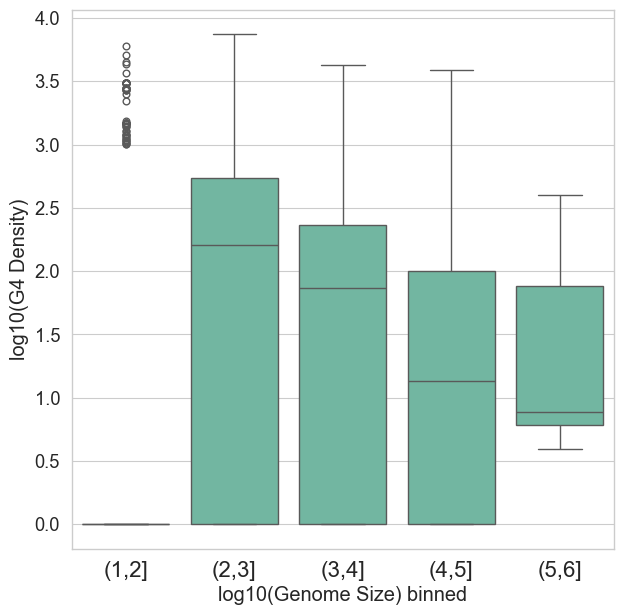

In [46]:
df_g4_virus = df_g4[df_g4['Domain'] == 'Virus']
# create new column with genome Size binned ( 0 means 0-0.99, 1 means 1-1.99 etc)
df_g4_virus["log10(Genome Size) binned"] = df_g4_virus["log10(Genome Size)"].apply(lambda x: int(x))

sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(7,7))
sns.boxplot(
    data=df_g4_virus,
    x="log10(Genome Size) binned",
    y="log10(G4 Density)",
    ax=ax
)
ax.set_xticklabels(["(1,2]", "(2,3]", "(3,4]", "(4,5]", "(5,6]"], fontsize=16)

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_9671/3406391442.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["(1,2]", "(2,3]", "(3,4]", "(4,5]", "(5,6]"], fontsize=16)


[Text(0, 0, '(1,2]'),
 Text(1, 0, '(2,3]'),
 Text(2, 0, '(3,4]'),
 Text(3, 0, '(4,5]'),
 Text(4, 0, '(5,6]')]

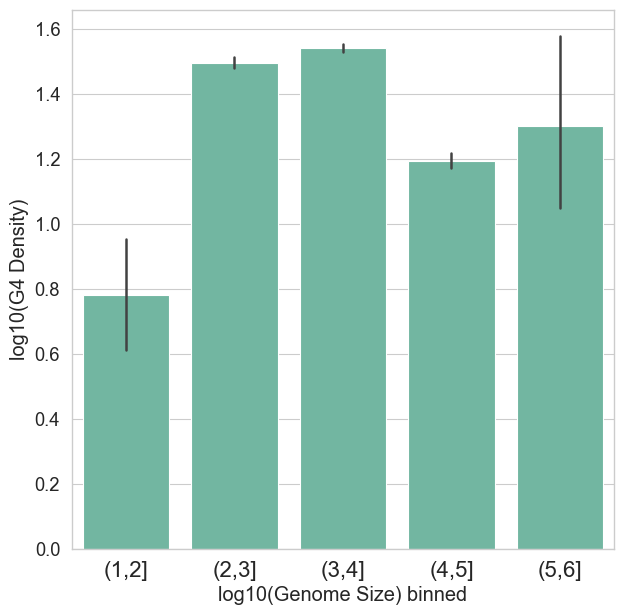

In [47]:
# barplot of genome size binning vs G4 density
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(
	data=df_g4_virus,
	x="log10(Genome Size) binned",
	y="log10(G4 Density)",
	ax=ax
)
ax.set_xticklabels(["(1,2]", "(2,3]", "(3,4]", "(4,5]", "(5,6]"], fontsize=16)
